In [1]:
import numpy as np
import keras
import tensorflow as tf
from scipy.special import erfc
from sklearn.manifold import TSNE
from keras.layers import Input, Dense, GaussianNoise, Lambda, Embedding, Flatten
from keras.models import Model
#from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as bkend
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
M = 4 # cardinalidade do conjunto de mensagens possiveis
k = int(np.log2(M)) # bits
n_ch = 2 # usos de canal
n_msg = 1000000 # número de mensagens transmitidas
EbNodB_train = 7 # SNR de treinamento [dB]
R = k/n_ch #taxa [bit/uso de canal]

NUM_EPOCHS = 5 # Número de épocas
BATCH_SIZE = 32 # Tamanho do batch

In [3]:
data_train = np.random.randint(M, size=n_msg)
data_train_pre = data_train.reshape((-1,1))

data_test = np.random.randint(M, size=n_msg)

# AUTOENCODER:
## CAMADAS DO TRANSMISSOR
input_signal = Input(shape=(1,)) 
encoded = Embedding(input_dim=M, output_dim=M, input_length=1)(input_signal)
encoded1 = Flatten()(encoded)
encoded2 = Dense(M, activation='relu')(encoded1)
encoded3 = Dense(n_ch, activation='linear')(encoded2)
encoded4 = Lambda(lambda x: np.sqrt(n_ch) * bkend.l2_normalize(x, axis=1))(encoded3)

## CANAL GAUSSIANO
EbNo_train = 10 ** (0.1*EbNodB_train)
channel_out = GaussianNoise(np.sqrt(1 / (2 * R * EbNo_train)))(encoded4)

## CAMADAS DO RECEPTOR
decoded = Dense(M, activation='relu')(channel_out)
decoded1 = Dense(M, activation='softmax')(decoded)

# Treino do Autodecoder
autoencoder = Model(input_signal, decoded1)
autoencoder.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy')
print(autoencoder.summary())
history = autoencoder.fit(data_train, data_train_pre, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose = 1)

# Encoder
encoder = Model(input_signal, encoded4)

# Decoder
encoded_input = Input(shape=(n_ch,))
deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

W0918 01:36:38.526833 13188 deprecation_wrapper.py:119] From c:\users\samuel\anaconda3\envs\autoencoder\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 01:36:38.541827 13188 deprecation_wrapper.py:119] From c:\users\samuel\anaconda3\envs\autoencoder\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 01:36:38.544826 13188 deprecation_wrapper.py:119] From c:\users\samuel\anaconda3\envs\autoencoder\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0918 01:36:38.600801 13188 deprecation_wrapper.py:119] From c:\users\samuel\anaconda3\envs\autoencoder\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehold

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1, 4)              16        
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 2)                 0   

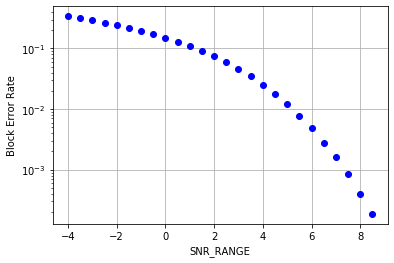

BER: [0.339146, 0.315582, 0.291607, 0.2683, 0.245728, 0.221274, 0.197303, 0.174164, 0.15105, 0.129651, 0.109907, 0.091049, 0.074122, 0.059225, 0.046104, 0.034581, 0.025188, 0.01785, 0.012169, 0.007833, 0.004852, 0.002805, 0.001609, 0.000865, 0.000401, 0.000186]


In [4]:
EbNodB_low = -4; EbNodB_high = 8.5; EbNodB_num = 26
EbNodB_range = list(np.linspace(EbNodB_low, EbNodB_high, EbNodB_num))
ber = [None] * len(EbNodB_range)
#data_test = data_test[:5000]
# ANÁLISE DE PERFORMANCE
## BLER
for n in range(0, len(EbNodB_range)):
    EbNo = 10 ** (0.1*EbNodB_range[n])
    noise_std = np.sqrt(1 / (2 * R * EbNo))
    n_err = 0
    awgn = noise_std * np.random.randn(n_msg, n_ch)
    # Transmissão 
    encoded_signal = encoder.predict(data_test)              
    final_signal = encoded_signal + awgn 
    # Recepção
    pred_final_signal = decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal, axis=1)
    # Numero de msg erradas
    n_err = (pred_output != data_test)
    n_err = n_err.astype(int).sum()
    ber[n] = n_err / n_msg
    #print('SNR:', EbNodB_range[n], 'BER:', ber[n])


plt.plot(EbNodB_range, ber,'bo')
plt.yscale('log')
plt.xlabel('SNR_RANGE')
plt.ylabel('Block Error Rate')
plt.grid()
plt.show()
print('BER:',ber)

In [5]:
data_test.shape

(1000000,)

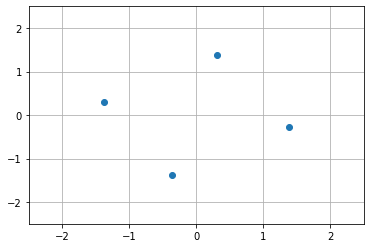

In [6]:
data_test = data_test[:1500]
if n_ch == 2:
    scatter_plot = []
    for i in range(0, M):
        scatter_plot.append(encoder.predict(np.expand_dims(i, axis=0)))
    scatter_plot = np.array(scatter_plot)
    scatter_plot = scatter_plot.reshape(M, 2, 1)
    plt.scatter(scatter_plot[:, 0], scatter_plot[:, 1], label='(%d, %d),'%(n_ch, int(np.log2(M))))
    plt.axis((-2.5, 2.5, -2.5, 2.5))
    plt.grid()
    plt.show()
     
                    
if n_ch > 2:
    x_emb = encoder.predict(data_test)
    #noise_std = np.sqrt(1 / (2 * R * EbNo_train))
    noise = noise_std * np.random.randn(len(data_test), n_ch)
    x_emb = x_emb + noise
    X_embedded = TSNE(n_components=2).fit_transform(x_emb)
    X_embedded = X_embedded / 7
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], label='(%d, %d)'%(n_ch, int(np.log2(M))))
    plt.legend()
    plt.grid()
    plt.show()